# ===========================================================
# Solve the estimation problem with convex optimization model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the convex optimization model
3. Compute train and test error

#### Last update: 03 Dec 2019

# Imports

In [84]:
from __future__ import division, print_function, absolute_import, unicode_literals

import cvxpy as cp
import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [110]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_with_only_first_influence.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'

# lambdaa = 1
test_fraction = 0.2
runs = 30

# Helper functions

In [111]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    else:
        raise ValueError('Wrong type_str was given.')

### Replicating more data by changing the order of members in the matrices

In [137]:
a[11]

{'content_embedding_matrix': array([[19, 20, 21, 22],
        [15, 16, 17, 18],
        [11, 12, 13, 14]]),
 'first_influence_matrices': matrix([[0.2 , 0.2 , 0.4 ],
         [0.25, 0.25, 0.25],
         [0.04, 0.04, 0.88]]),
 'individual_performance': array([0.67, 0.5 , 0.4 ])}

In [117]:
from itertools import permutations


def replicate_train_dataset(X_train, y_train):
    replicated_X_train = []
    replicated_y_train = []
    for index in range(len(X_train)):
        for order in permutations(np.arange(4)):
            rep_X_train_dt = {}
            rep_y_train_dt = {}
            for element_type, element in X_train[index].items():
                if len(element.shape) == 1:
                    rep_X_train_dt[element_type] = element[order]
                elif element.shape[0] == element.shape[1]:  # if it was a network:
                    rep_X_train_dt[element_type] = (
                        utils.shuffle_matrix_in_given_order(element, order))
                else:   # if it was a matrix of embeddings:
                    rep_X_train_dt[element_type] = (
                        element[order, :])
                rep_y_train_dt['influence_matrix'] = (
                    utils.shuffle_matrix_in_given_order(
                        y_train[index]['influence_matrix'], order))
            replicated_X_train.append(rep_X_train_dt)
            replicated_y_train.append(rep_y_train_dt)
    return replicated_X_train, replicated_y_train

In [113]:
# rep_X_train_small, rep_y_train_small = replicate_train_dataset(X_train_small, y_train_small)

# Loading the data

In [114]:
data = utils.load_it(data_fpath)
print(len(data['X']))

264


In [115]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'] / 100)

In [89]:
np.mean(mats, axis=0)

array([[0.00257846, 0.00250132, 0.00259172, 0.00232849],
       [0.00219973, 0.00324443, 0.00221875, 0.00233709],
       [0.002105  , 0.00250398, 0.00310839, 0.00228263],
       [0.00251803, 0.00238397, 0.00242936, 0.00266864]])

In [90]:
np.std(mats, axis=0)

array([[0.00116775, 0.000813  , 0.00089624, 0.00075369],
       [0.00089293, 0.00165879, 0.00083356, 0.00109168],
       [0.00089638, 0.00122138, 0.00168656, 0.00091934],
       [0.00095975, 0.00065094, 0.0005916 , 0.00087487]])

# Formulating the convex optimization problem

## With only average of previous influence matrices:

In [29]:
lambdaa = 0.1


model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

        constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
            A1 = element['average_of_previous_influence_matrices']
            pred_influence_matrix = A1 * W1 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
            constraints += [pred_influence_matrix >= 0]
            constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
        A1 = element['average_of_previous_influence_matrices']
        predicted_influence_matrix = A1 * W1.value + B.value
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 397.5254263045621
It took 13.94 seconds.
Run 1 ...
It was optimal and result was 411.98152392976135
It took 13.54 seconds.
Run 2 ...
It was optimal and result was 389.7733352088417
It took 13.62 seconds.
Run 3 ...
It was optimal and result was 398.5454805407402
It took 13.62 seconds.
Run 4 ...
It was optimal and result was 412.1563506715795
It took 13.29 seconds.
Run 5 ...
It was optimal and result was 426.3059417990221
It took 13.93 seconds.
Run 6 ...
It was optimal and result was 417.1745043630591
It took 13.21 seconds.
Run 7 ...
It was optimal and result was 443.12586409873853
It took 13.46 seconds.
Run 8 ...
It was optimal and result was 399.0217672440875
It took 13.27 seconds.
Run 9 ...
It was optimal and result was 415.22311511799785
It took 13.69 seconds.
Run 10 ...
It was optimal and result was 434.5889995937971
It took 14.05 seconds.
Run 11 ...
It was optimal and result was 401.34036786394074
It took 13.65 seconds.
Run 12 ...
It was opti

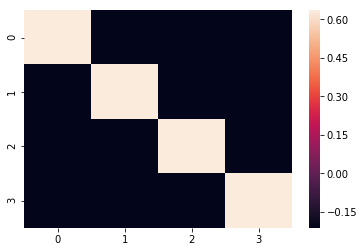

In [33]:
sns.heatmap(W1.value);

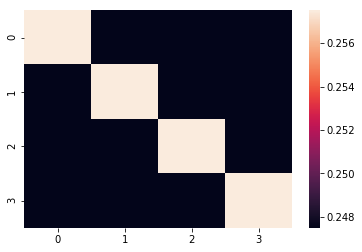

In [34]:
sns.heatmap(B.value);

random: 0.6257138866867928 +- 0.01604257548685887
uniform: 0.3371604198790437 +- 0.01908804176115327
model: 0.23749912395791864 +- 0.015044850361760172


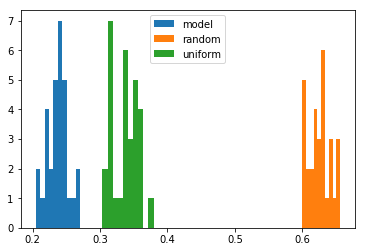

In [32]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

### Logistic function with only first influence matrix 

In [80]:
lambdaa = 0.1


model_errs = []
random_errs = []
uniform_errs = []

for run in range(2):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
            A1 = element['first_influence_matrices']

#             losses += cp.sum_entries( cp.logistic(-influence_matrix * (A1 * W1 + B)) )

            pred_influence_matrix = A1 * W1 + B
            losses += cp.sum_entries( cp.kl_div(influence_matrix, pred_influence_matrix) )

#             pred_influence_matrix = A1 * W1 + B
#             losses += cp.sum_squares(pred_influence_matrix - influence_matrix)
    
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective)  #, constraints)
        result = prob.solve(cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
        A1 = element['first_influence_matrices']
        predicted_influence_matrix = A1 * W1.value + B.value
#         predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It took 3.28 seconds.


SolverError: The solver MOSEK cannot solve the problem because it cannot solve exponential cone problems.

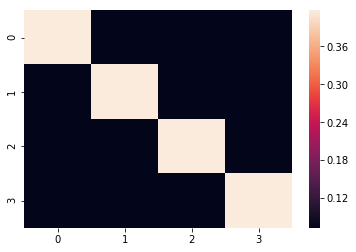

In [77]:
sns.heatmap(W1.value)

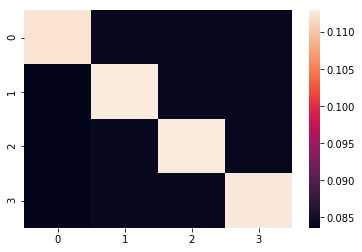

In [78]:
sns.heatmap(B.value)

random: 0.6174122674483592 +- 0.010745327398581805
uniform: 0.32959302075858365 +- 0.0013100443835122044
model: 0.3118306822846595 +- 0.014195220272253922


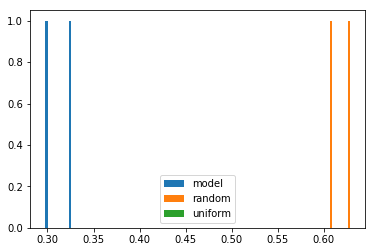

In [79]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## With only first influence matrix:

In [41]:
lambdaa = 0.1


model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
            A1 = element['first_influence_matrices']
            pred_influence_matrix = A1 * W1 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective)  #, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
        A1 = element['first_influence_matrices']
        predicted_influence_matrix = A1 * W1.value + B.value
        predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 706.2716566029851
It took 8.53 seconds.
Run 1 ...
It was optimal and result was 725.2967084206348
It took 8.15 seconds.
Run 2 ...
It was optimal and result was 729.3568777054649
It took 8.39 seconds.
Run 3 ...
It was optimal and result was 790.85751307092
It took 8.20 seconds.
Run 4 ...
It was optimal and result was 741.6704197589056
It took 8.04 seconds.
Run 5 ...
It was optimal and result was 730.4596655976875
It took 8.46 seconds.
Run 6 ...
It was optimal and result was 748.0404230169861
It took 8.10 seconds.
Run 7 ...
It was optimal and result was 745.8602492362488
It took 8.25 seconds.
Run 8 ...
It was optimal and result was 740.2080026737219
It took 8.38 seconds.
Run 9 ...
It was optimal and result was 751.6454826892564
It took 8.31 seconds.
Run 10 ...
It was optimal and result was 757.0639700348117
It took 8.34 seconds.
Run 11 ...
It was optimal and result was 722.5008307120946
It took 8.20 seconds.
Run 12 ...
It was optimal and result was

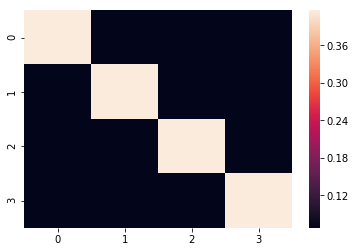

In [42]:
sns.heatmap(W1.value);

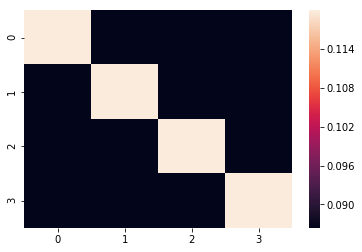

In [43]:
sns.heatmap(B.value);

random: 0.6243558196617354 +- 0.016342017290113944
uniform: 0.33383808379551116 +- 0.02051633468139265
model: 0.3046381312730851 +- 0.01656283321629026


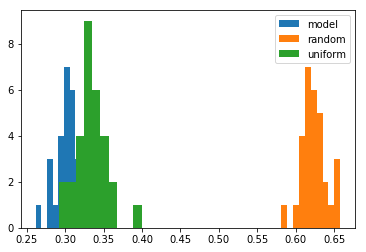

In [44]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

random: 0.6212294304253135 +- 0.01706147914657565
uniform: 0.3308111043908909 +- 0.019409182902447326
model: 0.3044930561618803 +- 0.016874360467564523


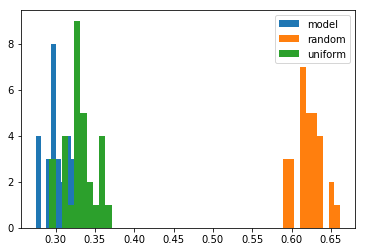

In [135]:
# Just the dataset itself:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## With individual performance

In [94]:
runs = 30

In [118]:
lambdaa = 0.1


model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        B = cp.Variable(4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
#             A1 = element['individual_performance']
            A1 = element['individual_performance_hardness_weighted']
            
            pred_influence_matrix = A1 * W1 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective)  #, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
#         A1 = element['individual_performance']
        A1 = element['individual_performance_hardness_weighted']
        
        predicted_influence_matrix = A1 * W1.value + B.value
        predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...


IndexError: too many indices for array

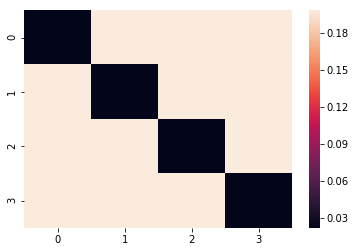

In [99]:
sns.heatmap(W1.value);

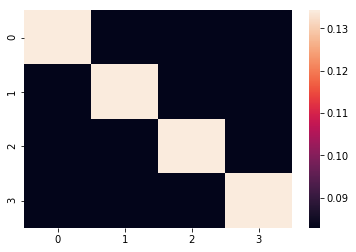

In [100]:
sns.heatmap(B.value);

random: 0.6261304994744514 +- 0.019004933846167745
uniform: 0.3329799173828974 +- 0.024271596167489643
model: 0.33163023062552327 +- 0.020147725093262882


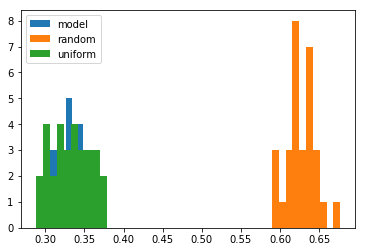

In [98]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## With first influence matrix and individual performance

In [102]:
lambdaa = 0.1


model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = utils.make_matrix_row_stochastic(
                y_train[index]['influence_matrix'])
            A1 = element['first_influence_matrices']
            A2 = element['individual_performance_hardness_weighted']
            
            pred_influence_matrix = A1 * W1 + A2 * W2 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective)  #, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = utils.make_matrix_row_stochastic(
            y_test[index]['influence_matrix'])

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
#         A1 = element['individual_performance']
        A1 = element['first_influence_matrices']
        A2 = element['individual_performance_hardness_weighted']
        
        predicted_influence_matrix = A1 * W1.value + A2 * W2.value + B.value
        predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 752.8551367587306
It took 10.13 seconds.
Run 1 ...
It was optimal and result was 768.0171835160534
It took 10.93 seconds.
Run 2 ...
It was optimal and result was 773.7905197323456
It took 10.70 seconds.
Run 3 ...
It was optimal and result was 739.4403960521051
It took 10.16 seconds.
Run 4 ...
It was optimal and result was 761.0724300609868
It took 10.98 seconds.
Run 5 ...
It was optimal and result was 753.184883683698
It took 10.35 seconds.
Run 6 ...
It was optimal and result was 746.673391380352
It took 10.22 seconds.
Run 7 ...
It was optimal and result was 712.2750056247528
It took 10.96 seconds.
Run 8 ...
It was optimal and result was 759.8270567765755
It took 9.93 seconds.
Run 9 ...
It was optimal and result was 746.9467463065687
It took 10.12 seconds.
Run 10 ...
It was optimal and result was 729.269768444929
It took 11.17 seconds.
Run 11 ...
It was optimal and result was 754.6224954486047
It took 9.92 seconds.
Run 12 ...
It was optimal and r

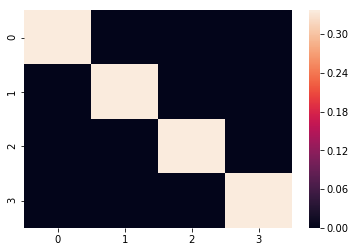

In [104]:
sns.heatmap(W1.value);

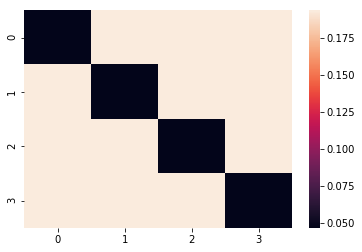

In [105]:
sns.heatmap(W2.value);

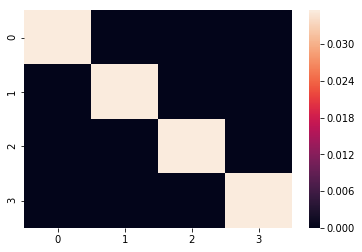

In [106]:
sns.heatmap(B.value);

random: 0.6210801990875476 +- 0.016990956153200173
uniform: 0.32966980214522484 +- 0.01594342988598879
model: 0.29839569506416663 +- 0.012987884736232235


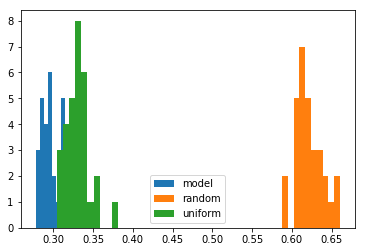

In [109]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## With previous influence matrices and all networks

In [10]:
with Timer():
    runs = 5
    lambdaas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9, 1, 2, 5, 10, 100, 1000, 10000]
    model_errs = defaultdict(list)
    for lambdaa in lambdaas:
        print('Lambda: ', lambdaa, '...')
        for run in range(runs):
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], test_size=test_fraction)

            X_train, y_train = replicate_train_dataset(X_train, y_train)

            # Solving the optimization problem.
            with Timer():
                W1 = cp.Variable(4, 4)
                W2 = cp.Variable(4, 4)
                W3 = cp.Variable(4, 4)
                B = cp.Variable(4, 4)
        #         constraints = []
                losses = 0
                for index in range(len(X_train)):
                    element = X_train[index]
                    influence_matrix = y_train[index]['influence_matrix']
        #             A1 = element['average_of_previous_influence_matrices']
                    A1 = element['first_influence_matrices']
                    A2 = element['reply_duration']
                    A3 = element['sentiment']
        #             A4 = element['emotion_arousal']
        #             A5 = element['emotion_dominance']
        #             A6 = element['emotion_valence']
                    pred_influence_matrix = A1 * W1 + A2 * W2 + A3 * W3 + B
                    loss = pred_influence_matrix - influence_matrix
                    losses += cp.sum_squares(loss)
        #             constraints += [pred_influence_matrix >= 0]
        #             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]
                regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(W3) + cp.norm1(B)
                objective = cp.Minimize(losses + lambdaa * regluarization)
                prob = cp.Problem(objective)  #, constraints)
                result = prob.solve(solver=cp.MOSEK)
                print('It was {} and result was {}'.format(prob.status, result))

            model_err = 0
            for index in range(len(X_test)):
                element = X_test[index]
                influence_matrix = y_test[index]['influence_matrix']
                # Optimization model prediction:
                A1 = element['first_influence_matrices']
                A2 = element['reply_duration']
                A3 = element['sentiment']
                predicted_influence_matrix = A1 * W1.value + A2 * W2.value + A3 * W3.value + B.value
        #         predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)  # << UNCOMMENT IT >>
                model_err += compute_matrix_err(
                    influence_matrix, predicted_influence_matrix)
            model_err /= len(X_test)
            model_errs[lambdaa].append(model_err)

Lambda:  0 ...
It was optimal and result was 774.3404126837133
It took 11.16 seconds.
It was optimal and result was 733.8603462826409
It took 11.82 seconds.
It was optimal and result was 788.1028787650718
It took 11.75 seconds.
It was optimal and result was 736.0690615283534
It took 11.57 seconds.
It was optimal and result was 715.7123595193837
It took 11.19 seconds.
Lambda:  0.01 ...
It was optimal and result was 747.9594359099096
It took 11.54 seconds.
It was optimal and result was 788.3432709367187
It took 11.46 seconds.
It was optimal and result was 741.1242171097603
It took 11.41 seconds.
It was optimal and result was 757.9979489954235
It took 10.76 seconds.
It was optimal and result was 766.9347954951454
It took 11.38 seconds.
Lambda:  0.05 ...
It was optimal and result was 754.5150471535087
It took 11.42 seconds.
It was optimal and result was 718.8985207087322
It took 10.70 seconds.
It was optimal and result was 764.655821458999
It took 11.43 seconds.
It was optimal and result w

In [11]:
errz = []
for lambdaa in lambdaas:
    print(lambdaa, ': ', np.mean(model_errs[lambdaa]), '+-', np.std(model_errs[lambdaa]))
    errz.append(np.mean(model_errs[lambdaa]))

0 :  0.3011743802652413 +- 0.020063083113073005
0.01 :  0.2963133866176929 +- 0.015973161966079022
0.05 :  0.3062668795795276 +- 0.013874774618744515
0.1 :  0.3095999597617864 +- 0.017819090728314457
0.2 :  0.2941185878549716 +- 0.02006738367903435
0.3 :  0.30257457579288827 +- 0.013306889155314812
0.5 :  0.3078848763423549 +- 0.005515771787705399
0.9 :  0.29270645819532487 +- 0.01848981548039053
1 :  0.30146502732172176 +- 0.015082943084012262
2 :  0.30887201679195064 +- 0.020579339692010812
5 :  0.30389845778067637 +- 0.014803297392890165
10 :  0.3096589878225967 +- 0.01617236135673211
100 :  0.3108994226093108 +- 0.015821189229998523
1000 :  0.4881974650919253 +- 0.01133999614957398
10000 :  0.9999999956332914 +- 3.214929424423093e-10


# Runs with tunned lambda

In [14]:
lambdaa = 0.9
runs = 30

model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        W2 = cp.Variable(4, 4)
        W3 = cp.Variable(4, 4)
#         W4 = cp.Variable(4, 4)
#         W5 = cp.Variable(4, 4)
#         W6 = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
#             A1 = element['average_of_previous_influence_matrices']
            A1 = element['first_influence_matrices']
            A2 = element['reply_duration']
            A3 = element['sentiment']
#             A4 = element['emotion_arousal']
#             A5 = element['emotion_dominance']
#             A6 = element['emotion_valence']
            pred_influence_matrix = A1 * W1 + A2 * W2 + A3 * W3 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(W3) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective)  #, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
#         A1 = element['average_of_previous_influence_matrices']
        A1 = element['first_influence_matrices']
        A2 = element['reply_duration']
        A3 = element['sentiment']
#         A4 = element['emotion_arousal']
#         A5 = element['emotion_dominance']
#         A6 = element['emotion_valence']
        predicted_influence_matrix = A1 * W1.value + A2 * W2.value + A3 * W3.value + B.value
#         predicted_influence_matrix = utils.make_matrix_row_stochastic(predicted_influence_matrix)  # << UNCOMMENT IT >>
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)
    #     err += frob_norm_of_difference
    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 766.3251177128855
It took 11.62 seconds.
Run 1 ...
It was optimal and result was 743.0657667529726
It took 11.66 seconds.
Run 2 ...
It was optimal and result was 779.2827421108643
It took 11.53 seconds.
Run 3 ...
It was optimal and result was 723.786987323808
It took 11.65 seconds.
Run 4 ...
It was optimal and result was 764.0087611851684
It took 11.66 seconds.
Run 5 ...
It was optimal and result was 778.6791052432029
It took 10.83 seconds.
Run 6 ...
It was optimal and result was 742.7187675187304
It took 11.65 seconds.
Run 7 ...
It was optimal and result was 764.5907057282249
It took 11.61 seconds.
Run 8 ...
It was optimal and result was 755.3111138466536
It took 10.99 seconds.
Run 9 ...
It was optimal and result was 730.3014073060064
It took 11.67 seconds.
Run 10 ...
It was optimal and result was 795.3035946067316
It took 10.83 seconds.
Run 11 ...
It was optimal and result was 758.2039140036177
It took 11.83 seconds.
Run 12 ...
It was optimal a

In [15]:
sum(np.array(uniform_errs) > np.array(model_errs)) / len(model_errs)

1.0

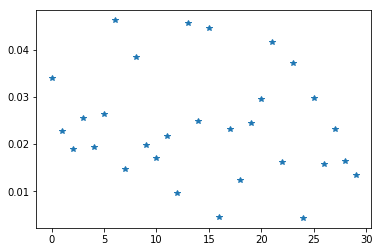

In [16]:
plt.plot(np.array(uniform_errs) - np.array(model_errs), '*');

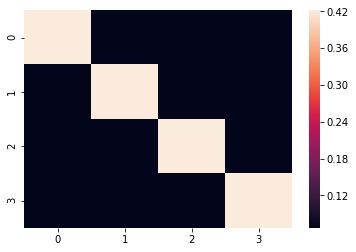

In [17]:
sns.heatmap(W1.value);

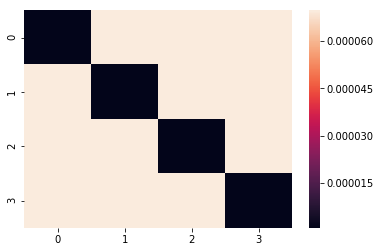

In [18]:
sns.heatmap(W2.value);

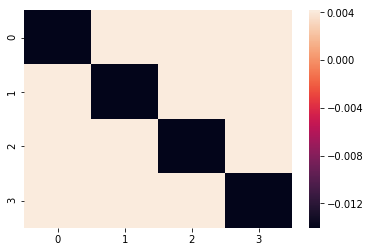

In [19]:
sns.heatmap(W3.value);

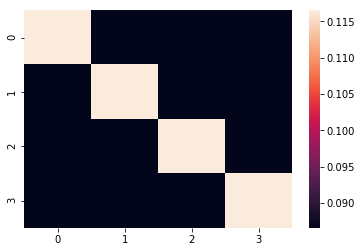

In [20]:
sns.heatmap(B.value);

random: 0.6266067853224059 +- 0.018992084881276246
uniform: 0.32490742121826355 +- 0.015290725245508025
model: 0.30085401151907765 +- 0.014900643430244422


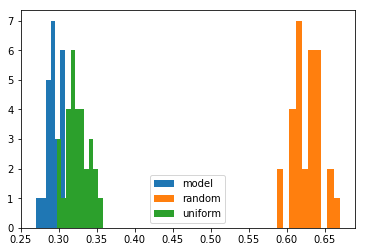

In [21]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

random: 0.6229028041996851 +- 0.016582563471854602
uniform: 0.3334930767269019 +- 0.0188187862459938
model: 0.30711267827334543 +- 0.015902166118144052


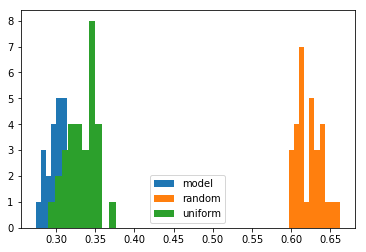

In [254]:
# With the data itself:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

random: 0.6256036346292906 +- 0.02295350141450487
uniform: 0.33512193590092 +- 0.019971630246377763
model: 0.2452193368273235 +- 0.014147432504710407


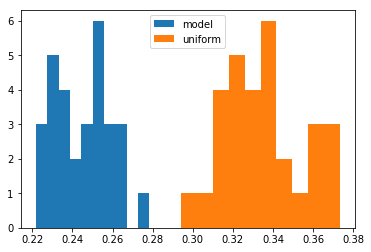

In [33]:
# plt.hist(model_errs)
# # plt.hist(random_errs)
# plt.hist(uniform_errs)
# # plt.legend(['model', 'random', 'uniform']);
# plt.legend(['model', 'uniform'])

# print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
# print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
# print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## With text embeddings and the first influence matrix:

In [ ]:
# with Timer():
#     runs = 5
#     lambdaas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9, 1, 2, 5, 10, 100, 1000, 10000]
#     model_errs = defaultdict(list)
#     for lambdaa in lambdaas:
#         print('Lambda: ', lambdaa, '...')
#         for run in range(runs):
#             X_train, X_test, y_train, y_test = train_test_split(
#                 data['X'], data['y'], test_size=test_fraction)

#             X_train, y_train = replicate_train_dataset(X_train, y_train)

#             # Solving the optimization problem.
#             with Timer():
#                 W1 = cp.Variable(4, 4)
#                 W2 = cp.Variable(768, 4)
#                 B = cp.Variable(4, 4)

#                 constraints = []
#                 losses = 0
#                 for index in range(len(X_train)):
#                     element = X_train[index]
#                     influence_matrix = y_train[index]['influence_matrix']
#                     A1 = element['first_influence_matrices']
#                     A2 = element['content_embedding_matrix']
#                     pred_influence_matrix = A1 * W1 + A2 * W2 + B
#                     loss = pred_influence_matrix - influence_matrix
#                     losses += cp.sum_squares(loss)
#                     constraints += [pred_influence_matrix >= 0]
#                     constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

#                 regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(B)
#                 objective = cp.Minimize(losses + lambdaa * regluarization)
#                 prob = cp.Problem(objective, constraints)
#                 result = prob.solve(solver=cp.MOSEK)
#                 print('It was {} and result was {}'.format(prob.status, result))

#             model_err = 0
#             for index in range(len(X_test)):
#                 element = X_test[index]
#                 influence_matrix = y_test[index]['influence_matrix']

#                 # Optimization model prediction:
#                 A1 = element['first_influence_matrices']
#                 A2 = element['content_embedding_matrix']
#                 predicted_influence_matrix = A1 * W1.value + A2 * W2.value + B.value
#                 model_err += compute_matrix_err(
#                     influence_matrix, predicted_influence_matrix)

#             model_err /= len(X_test)
#             model_errs[lambdaa].append(model_err)

Lambda:  0 ...


In [ ]:
# errz = []
# for lambdaa in lambdaas:
#     print(lambdaa, ': ', np.mean(model_errs[lambdaa]), '+-', np.std(model_errs[lambdaa]))
#     errz.append(np.mean(model_errs[lambdaa]))

# Runs

In [27]:
lambdaa = 0.01
runs = 30

In [28]:
model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    X_train, y_train = replicate_train_dataset(X_train, y_train)
    
    # Solving the optimization problem.
    with Timer():
        W1 = cp.Variable(4, 4)
        W2 = cp.Variable(768, 4)
        B = cp.Variable(4, 4)

#         constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix']
            A1 = element['first_influence_matrices']
            A2 = element['content_embedding_matrix']
            pred_influence_matrix = A1 * W1 + A2 * W2 + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
#             constraints += [pred_influence_matrix >= 0]
#             constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(B)
        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective) #, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix']

        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)

        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)

        # Optimization model prediction:
        A1 = element['first_influence_matrices']
        A2 = element['content_embedding_matrix']
        predicted_influence_matrix = A1 * W1.value + A2 * W2.value + B.value
        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)

    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 738.0406802933157
It took 3.19 minutes.
Run 1 ...
It was optimal and result was 751.5273380876821
It took 3.36 minutes.
Run 2 ...
It was optimal and result was 732.8557502720626
It took 3.33 minutes.
Run 3 ...
It was optimal and result was 758.8935324713053
It took 3.05 minutes.
Run 4 ...
It was optimal and result was 714.6307155223619
It took 3.38 minutes.
Run 5 ...
It was optimal and result was 796.9102394907536
It took 3.43 minutes.
Run 6 ...
It was optimal and result was 720.9420644937247
It took 3.47 minutes.
Run 7 ...
It was optimal and result was 753.1666222636954
It took 3.46 minutes.
Run 8 ...
It was optimal and result was 761.0843990840033
It took 3.40 minutes.
Run 9 ...
It was optimal and result was 749.0448410895319
It took 3.12 minutes.
Run 10 ...
It was optimal and result was 769.1520877541689
It took 2.92 minutes.
Run 11 ...
It was optimal and result was 739.5158216884324
It took 3.37 minutes.
Run 12 ...
It was optimal and result w

KeyboardInterrupt: 

random: 0.6269796734190237 +- 0.01995421860943538
uniform: 0.33240827017492997 +- 0.02336559677869273
model: 0.3027936262918508 +- 0.015856241631805136


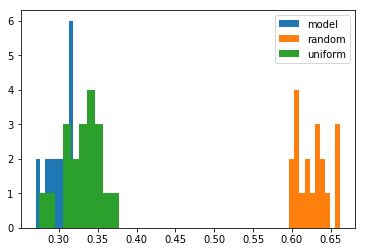

In [29]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);
# plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));